In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Energy 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),S&P 500 Energy (Sector) Outperform/Underperform,overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation
0,1993-01-04,435.38,90.74,-3.542548,-7.152359,UNDERPERFORM,143.100,104.300,100.500,118.900,160.800,160.800,131.800
1,1993-01-05,434.34,90.91,-3.116147,-7.395335,UNDERPERFORM,143.100,104.300,100.500,118.900,160.800,160.800,131.800
2,1993-01-06,434.52,90.89,-3.843856,-8.080502,UNDERPERFORM,143.100,104.300,100.500,118.900,160.800,160.800,131.800
3,1993-01-07,430.73,89.91,-4.320494,-9.200162,UNDERPERFORM,143.100,104.300,100.500,118.900,160.800,160.800,131.800
4,1993-01-08,429.05,88.90,-4.417662,-10.473313,UNDERPERFORM,143.100,104.300,100.500,118.900,160.800,160.800,131.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7280,2021-11-24,4701.46,436.37,4.852728,-18.023332,UNDERPERFORM,280.126,263.553,309.682,272.154,326.397,326.397,233.199
7281,2021-11-26,4594.62,418.74,1.616263,-19.629182,UNDERPERFORM,280.126,263.553,309.682,272.154,326.397,326.397,233.199
7282,2021-11-29,4655.27,421.22,1.484354,-19.563847,UNDERPERFORM,280.126,263.553,309.682,272.154,326.397,326.397,233.199
7283,2021-11-30,4567.00,410.70,1.396956,-21.037453,UNDERPERFORM,280.126,263.553,309.682,272.154,326.397,326.397,233.199


## Using data after 2010 (Best Model)

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),S&P 500 Energy (Sector) Outperform/Underperform,overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
204,2010,1,2010-01-14,1148.46,448.26,-2.110431,4.582147,OUTPERFORM,217.281,209.624,239.914,212.638,257.050,257.050,201.045,3
205,2010,2,2010-02-11,1078.47,417.06,-11.020997,-9.705774,OUTPERFORM,217.353,209.326,237.315,214.506,257.804,257.804,202.330,3
206,2010,3,2010-03-11,1150.24,434.70,5.750719,9.212873,OUTPERFORM,217.403,209.219,237.093,214.821,258.306,258.306,202.917,3
207,2010,4,2010-04-08,1186.44,442.81,6.168177,6.166535,UNDERPERFORM,217.290,206.631,232.440,214.303,258.969,258.969,203.124,3
208,2010,5,2010-05-13,1157.44,429.09,3.805347,5.539022,OUTPERFORM,217.199,203.764,227.477,213.427,259.454,259.454,203.501,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2021,7,2021-07-08,4320.82,391.55,-2.530346,6.045013,OUTPERFORM,273.092,242.958,276.734,262.483,326.470,326.470,229.005,3
343,2021,8,2021-08-12,4460.83,375.97,-1.849766,-14.466739,UNDERPERFORM,274.214,245.847,280.047,265.333,323.329,323.329,229.123,3
344,2021,9,2021-09-09,4493.28,357.55,-4.490556,-16.588905,UNDERPERFORM,276.590,255.010,293.342,270.870,323.995,323.995,231.525,3
345,2021,10,2021-10-14,4438.26,432.43,-7.366228,1.096460,OUTPERFORM,278.524,261.257,305.653,271.467,326.256,326.256,232.450,3


In [4]:
original = data[['S&P 500 Energy (Sector) Outperform/Underperform','month','overall','energy',\
                 'energy commodities','fuels and utilities','transportation','transportation services','utilities and public transportation']]

In [5]:
data.drop(columns=['date','S&P 500 Energy (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
204,1,1148.46,448.26,-2.110431,4.582147,217.281,209.624,239.914,212.638,257.050,257.050,201.045,3
205,2,1078.47,417.06,-11.020997,-9.705774,217.353,209.326,237.315,214.506,257.804,257.804,202.330,3
206,3,1150.24,434.70,5.750719,9.212873,217.403,209.219,237.093,214.821,258.306,258.306,202.917,3
207,4,1186.44,442.81,6.168177,6.166535,217.290,206.631,232.440,214.303,258.969,258.969,203.124,3
208,5,1157.44,429.09,3.805347,5.539022,217.199,203.764,227.477,213.427,259.454,259.454,203.501,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Energy (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','energy','energy commodities','fuels and utilities',\
                     'transportation','transportation services','utilities and public transportation']]

In [7]:
dd.data_summary(original)

,Info
Rows,143
Columns,9
Size in Memory,11.2 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.64,0.48,2,92
month,int64,0,0,1,6,12,6.46,3.43,12,12
overall,float64,0,0,217.20,238.033,280.13,241.91,14.66,141,2
energy,float64,0,0,176.40,218.54,263.55,221.44,21.49,143,1
energy commodities,float64,0,0,164.91,244.44,336.42,253.77,45.069,143,1
fuels and utilities,float64,0,0,212.64,233.35,272.15,233.33,12.69,143,1
transportation,float64,0,0,257.050,295.59,333.37,296.10,22.11,143,1
transportation services,float64,0,0,257.050,295.59,333.37,296.10,22.11,143,1
utilities and public transportation,float64,0,0,201.045,215.62,233.20,214.57,6.39,143,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

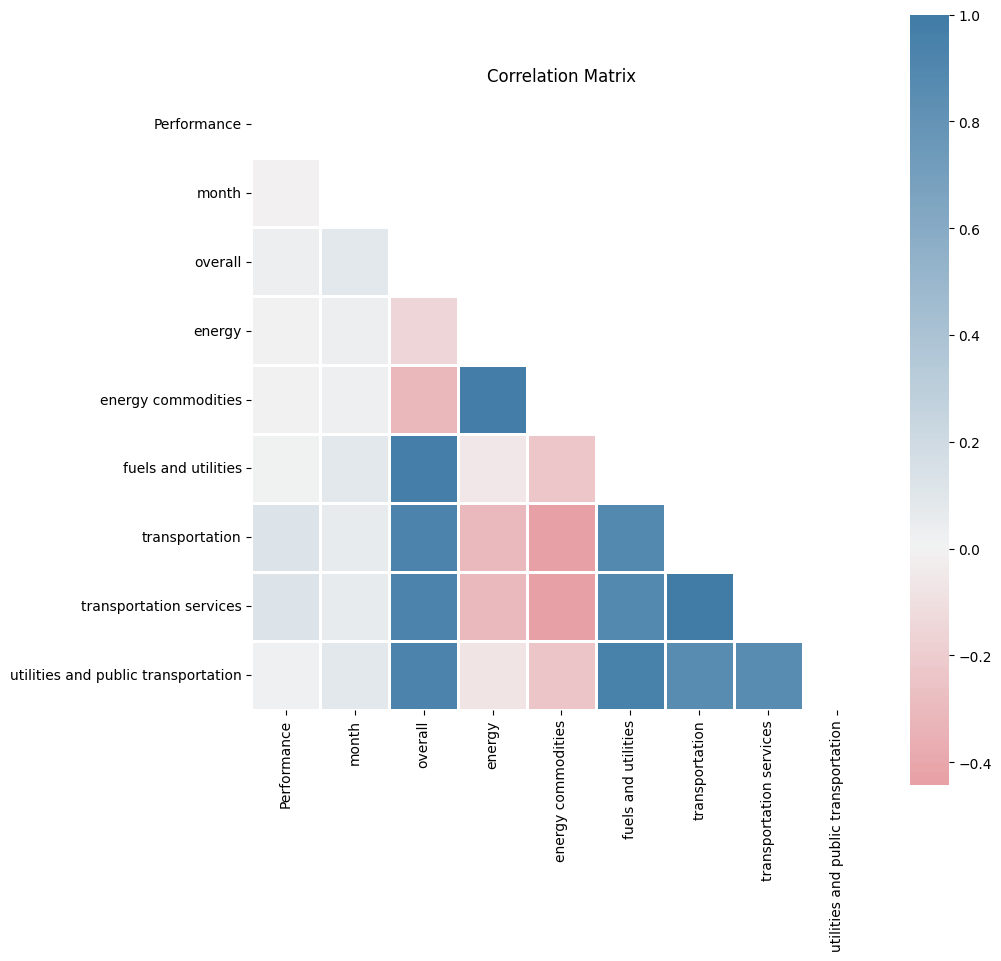

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
0,8,2498.312791,387.707371,11.359561,5.497371,261.502949,209.453548,222.892915,240.926019,291.094668,322.476123,217.115783,3
1,1,1183.013985,579.533553,-10.534965,-11.362010,237.512698,234.718165,301.411289,220.554352,281.570101,287.266713,211.508625,3
2,4,947.064272,445.318194,-2.792722,-2.634045,230.575340,233.264953,195.439400,225.887858,277.558689,272.825895,205.527097,3
3,1,1222.519593,432.539150,-6.937891,-9.412261,225.165578,207.128821,238.624318,220.974311,284.523423,289.461232,201.235205,3
4,4,1372.411117,488.072752,-3.363340,-3.224638,228.687108,205.022636,223.912410,222.224766,291.789665,287.629645,213.998494,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,12,2794.535450,556.885941,-3.784915,2.417154,240.385359,209.164621,219.065078,238.849521,295.008266,329.659452,216.836146,3
9996,1,2879.760423,557.691724,-0.952824,9.527372,247.494078,205.900041,215.761939,242.225875,304.022208,296.100175,217.681097,3
9997,4,1360.003082,563.896689,-4.691050,-11.247775,234.526788,238.231060,293.974838,226.952061,283.855371,285.315835,210.732305,3
9998,3,1193.654802,485.119223,-0.266577,11.327317,233.384305,201.069454,215.312015,220.183519,285.238764,271.324044,213.979832,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Energy (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month', 'overall','energy','energy commodities','fuels and utilities',\
                   'transportation','transportation services','utilities and public transportation']]
samples.head()

,Performance,month,overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation
0,0,8,261.502949,209.453548,222.892915,240.926019,291.094668,322.476123,217.115783
1,0,1,237.512698,234.718165,301.411289,220.554352,281.570101,287.266713,211.508625
2,1,4,230.575340,233.264953,195.439400,225.887858,277.558689,272.825895,205.527097
3,0,1,225.165578,207.128821,238.624318,220.974311,284.523423,289.461232,201.235205
4,1,4,228.687108,205.022636,223.912410,222.224766,291.789665,287.629645,213.998494


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,9
Size in Memory,703.2 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.74,0.44,2,7391
month,int64,0,0,1,6,12,6.50,3.43,12,866
overall,float64,0,0,211.077,241.074,294.34,245.54,16.85,10000,1
energy,float64,0,0,173.84,213.47,259.37,220.13,20.27,9999,2
energy commodities,float64,0,0,168.00,237.29,340.019,254.35,43.31,10000,1
fuels and utilities,float64,0,0,209.29,235.46,297.93,235.92,16.33,10000,1
transportation,float64,0,0,237.46,297.057,347.17,301.32,22.080,10000,1
transportation services,float64,0,0,234.30,295.47,344.69,299.25,22.50,9999,2
utilities and public transportation,float64,0,0,197.81,216.17,238.76,215.71,6.74,10000,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

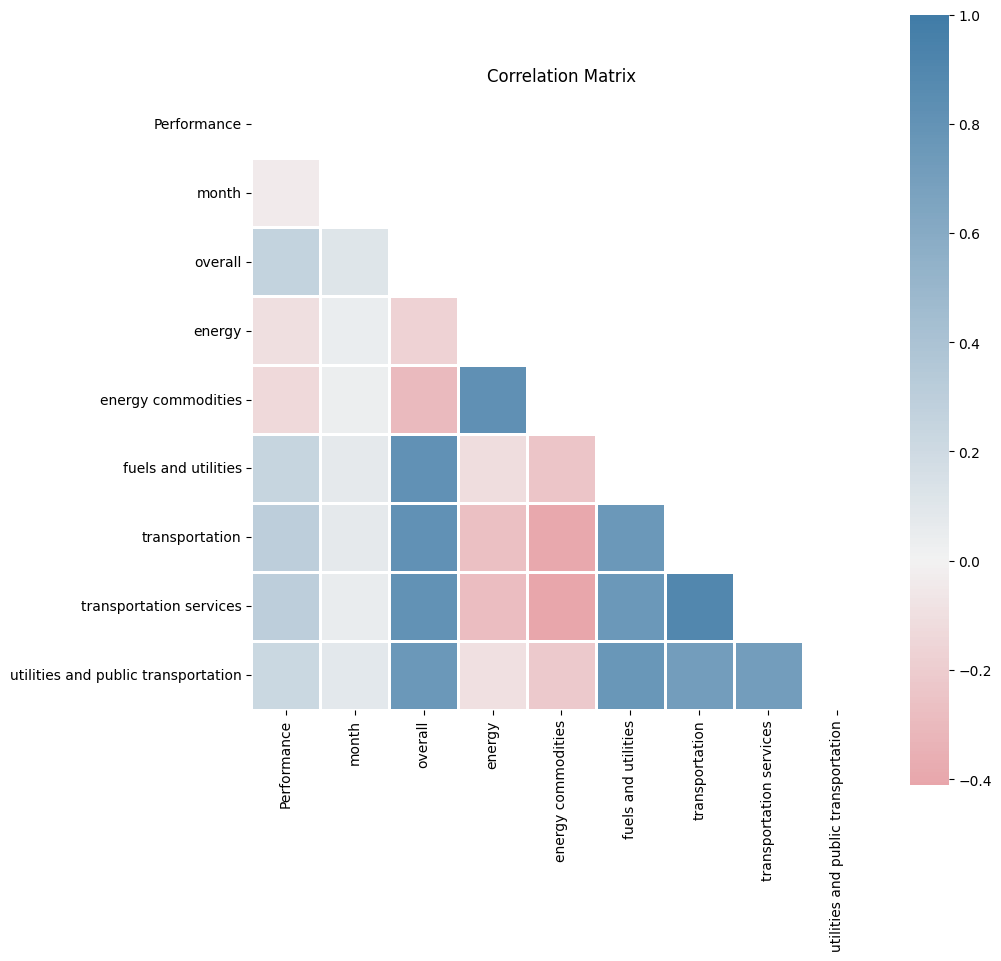

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({1: 7391, 0: 2609})
Counter({0: 7391, 1: 7391})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  261.50294946,   209.45354785,   222.89291492, ...,
        93871.07986154, 63201.24676366, 70014.6559363 ],
       [  237.5126976 ,   234.7181652 ,   301.4112887 , ...,
        80885.71727834, 59554.50492255, 60759.38744976],
       [  230.57534011,   233.26495297,   195.43940022, ...,
        75725.1976955 , 57045.83155643, 56073.1139802 ],
       ...,
       [  224.05825135,   235.36317976,   291.1921954 , ...,
        70244.93160847, 55067.99165149, 55119.58369643],
       [  232.66182311,   243.87485333,   300.1930133 , ...,
        75736.40401111, 56870.14737333, 57481.09399215],
       [  225.4253568 ,   244.97914819,   310.58101199, ...,
        78167.00370696, 59085.92830557, 57841.0730473 ]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(14782, 29)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(143, 29)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.764041,0.851417,0.642805,0.731815,0.751082,0.836634,0.631944,0.720024,0.538462,0.658537,0.586957,0.62069
1,DecisionTreeClassifier,0.742731,0.763931,0.705183,0.732942,0.730249,0.763713,0.676816,0.717644,0.559441,0.679012,0.597826,0.635838
2,RandomForestClassifier,0.832164,0.879971,0.772018,0.821743,0.801677,0.85176,0.736645,0.790032,0.601399,0.692308,0.684783,0.688525
3,AdaBoostClassifier,0.698755,0.716389,0.658772,0.686146,0.689935,0.714033,0.646902,0.678812,0.566434,0.727273,0.521739,0.607595
4,GradientBoostingClassifier,0.714045,0.736553,0.66689,0.699847,0.700216,0.732927,0.642094,0.68451,0.545455,0.714286,0.48913,0.580645
5,ExtraTreesClassifier,0.866193,0.91069,0.814367,0.859251,0.832522,0.882245,0.772436,0.823697,0.608392,0.683673,0.728261,0.705263
6,BaggingClassifier,0.79137,0.866169,0.691111,0.768269,0.770833,0.840532,0.675748,0.749186,0.58042,0.690476,0.630435,0.659091
7,SVC,0.686782,0.705982,0.640508,0.671568,0.67776,0.708002,0.619124,0.660587,0.559441,0.730159,0.5,0.593548
8,GaussianNB,0.664592,0.703335,0.56961,0.629395,0.656115,0.702357,0.557158,0.621388,0.524476,0.7,0.456522,0.552632


### Voting Classifier

In [21]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.813582,0.862661,0.751603,0.803311


## Using data after 2000

In [22]:
data = pd.read_csv('../data/S&P 500 Energy 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2000]
data

,year,month,date,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),S&P 500 Energy (Sector) Outperform/Underperform,overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
84,2000,1,2000-01-13,1449.68,219.62,-4.867901,5.622084,OUTPERFORM,170.000,118.800,122.400,134.500,193.600,193.600,149.400,3
85,2000,2,2000-02-10,1416.83,196.08,-0.911278,-9.066456,UNDERPERFORM,171.000,124.300,133.400,133.600,194.400,194.400,149.800,3
86,2000,3,2000-03-09,1401.69,212.05,-0.373858,-8.760380,UNDERPERFORM,170.900,120.900,126.100,133.700,194.700,194.700,150.000,3
87,2000,4,2000-04-13,1440.51,215.82,-1.016965,-6.099896,UNDERPERFORM,171.200,120.000,124.100,133.800,195.500,195.500,150.300,3
88,2000,5,2000-05-11,1407.81,230.91,-3.857159,10.499115,OUTPERFORM,172.200,126.800,134.900,136.600,196.000,196.000,151.500,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2021,7,2021-07-08,4320.82,391.55,-2.530346,6.045013,OUTPERFORM,273.092,242.958,276.734,262.483,326.470,326.470,229.005,3
343,2021,8,2021-08-12,4460.83,375.97,-1.849766,-14.466739,UNDERPERFORM,274.214,245.847,280.047,265.333,323.329,323.329,229.123,3
344,2021,9,2021-09-09,4493.28,357.55,-4.490556,-16.588905,UNDERPERFORM,276.590,255.010,293.342,270.870,323.995,323.995,231.525,3
345,2021,10,2021-10-14,4438.26,432.43,-7.366228,1.096460,OUTPERFORM,278.524,261.257,305.653,271.467,326.256,326.256,232.450,3


In [23]:
original = data[['S&P 500 Energy (Sector) Outperform/Underperform','month','overall','energy',\
                 'energy commodities','fuels and utilities','transportation','transportation services','utilities and public transportation']]
data.drop(columns=['date','S&P 500 Energy (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Energy (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','energy','energy commodities','fuels and utilities',\
                     'transportation','transportation services','utilities and public transportation']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
0,4,1249.790854,516.968436,3.530084,-3.874031,222.698655,235.642492,293.836804,211.434948,277.680880,257.192175,208.621319,3
1,3,1282.919423,461.987408,-2.529406,-5.777301,192.557832,204.734161,153.548829,143.282017,257.818549,224.225548,167.408167,3
2,1,1912.471046,543.421747,7.395216,5.043921,231.905276,233.999289,301.804150,232.119222,291.151541,300.283995,208.768527,3
3,8,2102.313805,505.659106,-4.208269,-9.135177,258.202160,210.276977,219.839036,254.106349,302.706719,295.785295,217.931709,3
4,5,1238.903393,235.499063,-0.829314,2.390825,177.342288,199.140422,231.624033,142.287737,264.995436,224.540689,160.953397,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3,2989.637157,414.089288,-10.798221,-11.993851,255.522660,212.030515,223.440275,239.855734,321.313785,249.215979,218.494758,3
9996,7,1259.300367,589.572367,7.407739,5.027036,228.918213,237.211660,327.186443,226.318735,271.837392,261.576785,211.755476,3
9997,2,2161.832828,503.769695,0.891519,2.612280,252.978379,210.863016,217.550798,250.364021,325.244740,304.453215,222.590224,3
9998,11,947.877257,438.213187,0.991277,21.931981,219.676517,196.345084,212.664717,190.335674,213.398691,214.634665,185.241597,3


In [24]:
samples['Performance'] = np.where(samples['S&P 500 Energy (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','energy','energy commodities','fuels and utilities',\
                   'transportation','transportation services','utilities and public transportation']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.593049,0.593012,0.593258,0.593,0.590548,0.588967,0.601587,0.59521,0.585551,0.606897,0.628571,0.617544
1,DecisionTreeClassifier,0.566733,0.566871,0.566236,0.566449,0.565131,0.565424,0.565873,0.565649,0.543726,0.574627,0.55,0.562044
2,RandomForestClassifier,0.619265,0.623616,0.603183,0.613025,0.606831,0.61102,0.589683,0.600162,0.589354,0.615942,0.607143,0.611511
3,AdaBoostClassifier,0.638332,0.635544,0.649062,0.642061,0.641382,0.637202,0.657937,0.647403,0.581749,0.619048,0.557143,0.586466
4,GradientBoostingClassifier,0.650248,0.6487,0.655612,0.652003,0.650913,0.651551,0.65,0.650775,0.593156,0.641026,0.535714,0.583658
5,ExtraTreesClassifier,0.607051,0.60968,0.595841,0.602404,0.606831,0.609578,0.596032,0.602729,0.593156,0.620438,0.607143,0.613718
6,BaggingClassifier,0.607249,0.626215,0.533075,0.575691,0.584194,0.600188,0.506349,0.54929,0.604563,0.655172,0.542857,0.59375
7,SVC,0.612314,0.617134,0.591269,0.603787,0.607625,0.619929,0.557937,0.587302,0.596958,0.666667,0.485714,0.561983
8,GaussianNB,0.59136,0.570884,0.735855,0.642926,0.593725,0.571515,0.751587,0.649297,0.608365,0.608187,0.742857,0.66881


## Using all data

In [25]:
data = pd.read_csv('../data/S&P 500 Energy 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),S&P 500 Energy (Sector) Outperform/Underperform,overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
0,1993,1,1993-01-14,435.94,89.26,-2.644156,-10.543195,UNDERPERFORM,143.100,104.300,100.500,118.900,160.800,160.800,131.800,3
1,1993,2,1993-02-11,447.66,95.06,3.256908,-4.366197,UNDERPERFORM,143.300,104.900,99.900,120.300,160.500,160.500,132.500,3
2,1993,3,1993-03-11,453.72,96.61,1.767450,-4.705070,UNDERPERFORM,143.800,104.900,99.400,120.700,161.000,161.000,133.100,3
3,1993,4,1993-04-08,441.84,102.81,-0.981579,0.000000,OUTPERFORM,144.200,104.300,97.500,121.100,162.300,162.300,134.200,3
4,1993,5,1993-05-13,439.23,101.48,-2.195551,-0.108278,OUTPERFORM,144.300,103.900,96.400,121.400,162.600,162.600,134.700,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2021,7,2021-07-08,4320.82,391.55,-2.530346,6.045013,OUTPERFORM,273.092,242.958,276.734,262.483,326.470,326.470,229.005,3
343,2021,8,2021-08-12,4460.83,375.97,-1.849766,-14.466739,UNDERPERFORM,274.214,245.847,280.047,265.333,323.329,323.329,229.123,3
344,2021,9,2021-09-09,4493.28,357.55,-4.490556,-16.588905,UNDERPERFORM,276.590,255.010,293.342,270.870,323.995,323.995,231.525,3
345,2021,10,2021-10-14,4438.26,432.43,-7.366228,1.096460,OUTPERFORM,278.524,261.257,305.653,271.467,326.256,326.256,232.450,3


In [26]:
original = data[['S&P 500 Energy (Sector) Outperform/Underperform','month','overall','energy',\
                 'energy commodities','fuels and utilities','transportation','transportation services','utilities and public transportation']]
data.drop(columns=['date','S&P 500 Energy (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Energy (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','energy','energy commodities','fuels and utilities',\
                     'transportation','transportation services','utilities and public transportation']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
0,2,643.004227,79.324476,-2.197536,-5.854903,161.898524,115.939261,96.361575,132.859436,162.288719,192.509456,146.870877,3
1,5,1866.524069,456.357199,1.209574,11.007328,222.023124,162.260496,156.686257,223.819133,311.987248,239.767184,208.313834,3
2,7,1967.914653,497.541299,0.446559,4.153484,197.111440,223.574301,269.100020,194.330164,186.949345,219.043914,189.303053,3
3,10,1263.019896,200.434670,-4.469813,-6.602116,197.552801,118.737681,111.626006,148.502307,216.064339,225.000776,169.177606,3
4,10,466.200473,151.977946,-9.329484,-5.590178,162.277278,183.954098,248.750535,212.820456,295.528613,241.448789,195.691096,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7,1311.511808,562.046064,7.029006,1.200652,238.756321,240.385832,317.808742,228.217593,317.339545,246.627159,220.241849,3
9996,1,1496.090010,286.245540,7.728709,13.769685,192.851470,141.899910,147.485999,158.583879,203.682003,208.575895,176.398911,3
9997,10,591.583960,53.096106,-7.448587,-8.166468,136.654738,93.503268,84.294687,111.133791,165.068791,161.555600,135.315909,3
9998,1,1448.872084,159.629509,5.361728,2.130671,219.604597,187.712677,168.457424,137.761569,196.535094,210.884987,155.519700,3


In [27]:
samples['Performance'] = np.where(samples['S&P 500 Energy (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','energy','energy commodities','fuels and utilities',\
                   'transportation','transportation services','utilities and public transportation']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.675155,0.705329,0.609053,0.652816,0.672505,0.713303,0.602324,0.653133,0.56196,0.59887,0.566845,0.582418
1,DecisionTreeClassifier,0.652687,0.666817,0.62558,0.644032,0.659286,0.678129,0.63654,0.656677,0.587896,0.617021,0.620321,0.618667
2,RandomForestClassifier,0.738859,0.768167,0.698612,0.729568,0.727032,0.75693,0.68754,0.720568,0.570605,0.609195,0.566845,0.587258
3,AdaBoostClassifier,0.67234,0.685327,0.637975,0.660718,0.674818,0.703091,0.631375,0.665306,0.628242,0.68125,0.582888,0.628242
4,GradientBoostingClassifier,0.680852,0.691386,0.654005,0.672083,0.688698,0.712982,0.655907,0.683255,0.62536,0.686275,0.561497,0.617647
5,ExtraTreesClassifier,0.753814,0.785496,0.717777,0.747078,0.748182,0.777308,0.712072,0.743261,0.579251,0.606218,0.625668,0.615789
6,BaggingClassifier,0.699116,0.74586,0.61236,0.671369,0.688367,0.750413,0.586185,0.658209,0.56196,0.60355,0.545455,0.573034
7,SVC,0.662015,0.674931,0.624923,0.648901,0.666226,0.702784,0.60297,0.649062,0.613833,0.66879,0.561497,0.610465
8,GaussianNB,0.599883,0.636808,0.464803,0.537174,0.590218,0.638814,0.459006,0.534185,0.570605,0.661017,0.417112,0.511475
